# HOCNN

In [4]:
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import cv2
import numpy as np
import json
from PIL import Image

from model.cnn_model import HOCNN

In [45]:
model = "hico/v2_nl2_2020-11-20_09-57/"
checkpoint_path = "checkpoint_25_epoch.pth"
#model = "hico/v2_nl2_2020-11-23_00-07/"
#checkpoint_path = "checkpoint_130_epoch.pth"

PATH = "checkpoints/" + model + "epoch_train/" + checkpoint_path

In [46]:
import os

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='4' # Change this ID to an unused GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(PATH, map_location=device)
model = HOCNN().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("model loaded")

model loaded


In [21]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
faster_rcnn.eval()
print("faster rcnn loaded")

faster rcnn loaded


In [22]:
coco_dict = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

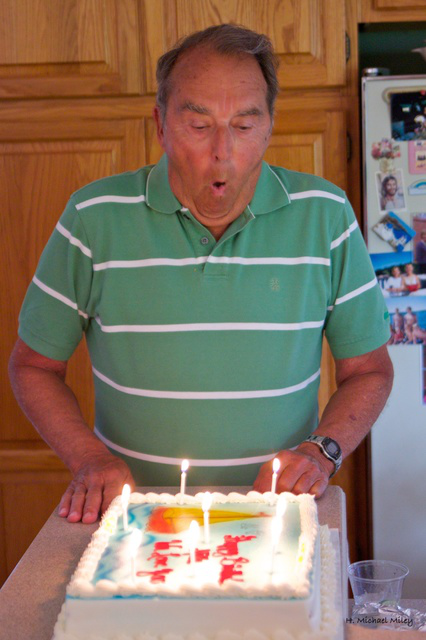

In [23]:
IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_00000009.jpg"
im = Image.open(IMG_PATH)
display(im)

In [26]:
src = cv2.imread(IMG_PATH)
src = src/255
img_tensor = torch.from_numpy(src)
img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
rcnn_input = [img_tensor]

In [27]:
out = faster_rcnn(rcnn_input)[0]
out

{'boxes': tensor([[  0.0000,  29.3527, 410.3438, 547.7892],
         [ 67.4866, 488.2460, 330.5525, 606.1885],
         [347.2623, 558.2026, 412.8515, 624.3336],
         [ 12.5524, 468.0038, 417.7606, 632.3345],
         [358.6635,  88.6779, 426.0000, 320.8906],
         [361.9977, 123.9592, 426.0000, 607.4264],
         [389.5260, 307.3471, 404.5960, 344.4699],
         [324.5523, 440.3854, 340.4584, 460.1184],
         [402.6273, 306.9961, 422.7122, 343.1232],
         [119.4921, 487.9740, 286.0997, 530.7411],
         [145.8628, 504.3513, 204.2614, 539.1113],
         [ 49.9289, 550.0607, 422.3012, 634.7078],
         [346.2032, 558.2308, 414.3589, 631.4077],
         [262.0466, 453.6846, 286.1371, 496.1225],
         [378.9313, 171.4407, 402.1549, 211.3226],
         [326.3437, 442.7421, 338.4034, 455.1187],
         [ 22.3151, 449.4126, 341.5482, 556.0033],
         [369.2597, 209.8030, 415.4822, 250.1928],
         [140.8204, 497.7518, 237.4800, 542.0735],
         [313.7404, 43

In [47]:
human_bboxes, object_bboxes = [], []
object_dic = {}
for i in range(len(out['boxes'])):
    if out['scores'][i] < .9:
        break
    bbox = list(map(int, out['boxes'][i]))
    if out['labels'][i] == 1: # human
        human_bboxes.append(bbox)
    else: 
        object_bboxes.append(bbox)
        object_dic[coco_dict[out['labels'][i]]] = bbox
        
print(human_bboxes, object_bboxes)
print(object_dic)

[[0, 29, 410, 547]] [[67, 488, 330, 606], [347, 558, 412, 624]]
{'cake': [67, 488, 330, 606], 'cup': [347, 558, 412, 624]}


In [48]:
# apply masks
src = cv2.imread(IMG_PATH)
human_mask = np.zeros_like(src)
for bbox in human_bboxes:
    cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

obj_mask = np.zeros_like(src)
pairwise_mask = human_mask
for bbox in object_bboxes:
    cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

# resize images
human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
#pose_img = cv2.resize(pose_img, (64, 64), interpolation=cv2.INTER_AREA)

human_bbox_img = human_bbox_img/255
obj_bbox_img = obj_bbox_img/255
pairwise_bbox_img = pairwise_bbox_img/255

human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)
#pose_img = torch.from_numpy(pose_img).to(device)

res_human_input = human_bbox_img.unsqueeze(0)
res_obj_input = obj_bbox_img.unsqueeze(0)
res_pairwise_input = pairwise_bbox_img.unsqueeze(0)
#res_pose_input = pose_img.unsqueeze(0)

res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)

In [49]:
with torch.no_grad(): # Disable gradients for validation
    outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)

    preds = torch.argmax(outputs, dim=1)
   # ground_labels = torch.max(labels, 1)[1]

In [50]:
with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
prediction = hoi_list[preds.item()]
print(prediction)

{'id': '251', 'object': 'book', 'verb': 'read'}


## HOCNN With Random ID

[[169, 146, 225, 227], [245, 167, 281, 223]] [[128, 189, 359, 258]]
{'boat': [128, 189, 359, 258]}


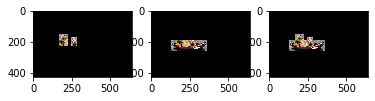

[*] Predictions
[1] snowboard wear 7.15%
[2] skateboard jump 6.85%
[3] snowboard stand_on 5.88%
[4] snowboard jump 5.19%
[5] skateboard ride 5.04%
Ground truth: boat row
[[436, 214, 453, 241]] [[254, 163, 631, 387], [0, 111, 224, 413], [58, 81, 628, 388]]
{'truck': [58, 81, 628, 388]}


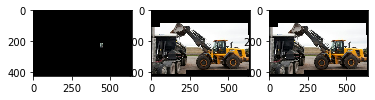

[*] Predictions
[1] car no_interaction 8.74%
[2] airplane sit_on 7.78%
[3] train no_interaction 7.39%
[4] train ride 5.97%
[5] airplane direct 5.55%
Ground truth: truck inspect
[[193, 49, 432, 354], [74, 0, 178, 268]] [[83, 167, 520, 432]]
{'bicycle': [83, 167, 520, 432]}


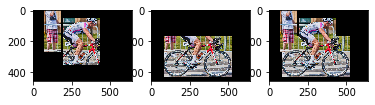

[*] Predictions
[1] bicycle straddle 39.9%
[2] bicycle ride 35.46%
[3] bicycle hold 22.43%
[4] bicycle sit_on 21.27%
[5] motorcycle straddle 9.8%
Ground truth: bicycle inspect
[[64, 5, 297, 456], [337, 0, 515, 426], [420, 9, 640, 474], [418, 212, 447, 263]] [[347, 9, 435, 208], [468, 2, 617, 169], [117, 13, 289, 233]]
{'handbag': [117, 13, 289, 233], 'backpack': [468, 2, 617, 169]}


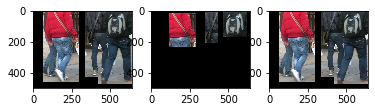

[*] Predictions
[1] bench sit_on 8.23%
[2] tie wear 3.81%
[3] person hold 3.63%
[4] skis stand_on 3.28%
[5] skis wear 2.44%
Ground truth: backpack hold
[[211, 69, 628, 419], [7, 12, 311, 340], [17, 14, 542, 414]] [[378, 293, 530, 385], [385, 296, 454, 325]]
{'toothbrush': [385, 296, 454, 325]}


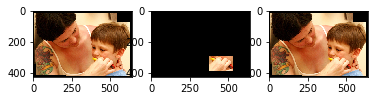

[*] Predictions
[1] toothbrush brush_with 11.2%
[2] toothbrush hold 9.72%
[3] apple hold 8.91%
[4] bottle hold 6.51%
[5] cake blow 5.97%
Ground truth: toothbrush hold
[[11, 5, 510, 480]] [[345, 159, 432, 473]]
{'toothbrush': [345, 159, 432, 473]}


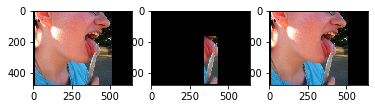

[*] Predictions
[1] tie wear 4.78%
[2] apple hold 4.74%
[3] person hold 4.54%
[4] toothbrush hold 4.41%
[5] bottle hold 4.24%
Ground truth: knife lick
[[324, 14, 640, 416], [9, 1, 486, 423]] [[160, 10, 220, 153], [402, 256, 456, 384]]
{'bottle': [160, 10, 220, 153], 'cell phone': [402, 256, 456, 384]}


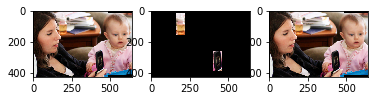

[*] Predictions
[1] tie wear 8.26%
[2] cell_phone hold 5.08%
[3] wine_glass hold 3.4%
[4] bottle no_interaction 2.61%
[5] cell_phone talk_on 2.28%
Ground truth: cell_phone read
[[527, 340, 638, 425]] [[487, 220, 549, 324], [559, 195, 632, 269], [211, 179, 270, 234], [66, 286, 189, 411], [88, 245, 183, 295], [413, 226, 471, 315], [121, 184, 163, 238], [341, 200, 381, 278], [252, 209, 305, 284], [380, 187, 412, 246], [287, 230, 343, 276], [0, 299, 36, 426], [227, 266, 391, 410], [15, 277, 85, 369], [459, 181, 523, 222], [155, 203, 233, 239], [409, 198, 490, 241], [201, 223, 245, 261], [12, 264, 88, 317]]
{'cow': [12, 264, 88, 317]}


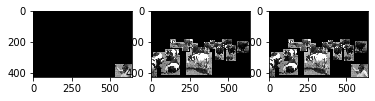

[*] Predictions
[1] skis wear 17.3%
[2] skis stand_on 16.36%
[3] bench sit_on 13.92%
[4] boat ride 7.6%
[5] skis ride 7.39%
Ground truth: dining_table clean
[[138, 54, 214, 221]] []
{}


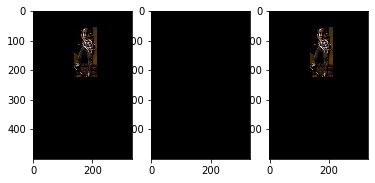

[*] Predictions
[1] skateboard jump 20.76%
[2] skateboard ride 19.78%
[3] skateboard stand_on 16.48%
[4] snowboard jump 12.07%
[5] snowboard wear 11.84%
Ground truth: skateboard sit_on
[[0, 238, 164, 416]] [[370, 133, 447, 231], [222, 177, 422, 298], [428, 350, 485, 374]]
{'broccoli': [370, 133, 447, 231], 'bowl': [428, 350, 485, 374]}


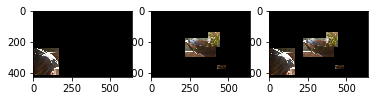

[*] Predictions
[1] bench sit_on 9.55%
[2] motorcycle sit_on 8.31%
[3] motorcycle straddle 7.48%
[4] motorcycle ride 5.4%
[5] motorcycle hold 4.55%
Ground truth: broccoli wash
[[99, 36, 533, 427]] [[19, 251, 36, 342], [74, 248, 87, 319], [63, 253, 80, 322], [115, 228, 126, 302]]
{'book': [115, 228, 126, 302]}


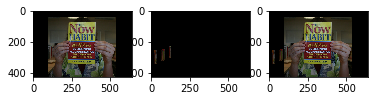

[*] Predictions
[1] book read 5.59%
[2] wine_glass hold 5.13%
[3] book hold 4.78%
[4] apple hold 4.75%
[5] bottle hold 4.15%
Ground truth: book open
[[168, 242, 250, 487], [309, 255, 418, 454]] [[314, 145, 425, 262], [5, 46, 156, 131], [305, 288, 342, 376], [184, 282, 236, 356]]
{'car': [5, 46, 156, 131], 'handbag': [305, 288, 342, 376], 'backpack': [184, 282, 236, 356]}


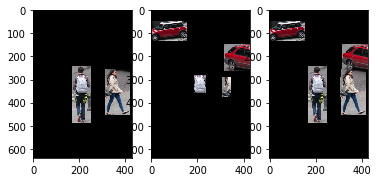

[*] Predictions
[1] skateboard ride 4.78%
[2] skateboard stand_on 4.44%
[3] tie wear 3.32%
[4] umbrella carry 3.27%
[5] skateboard jump 3.03%
Ground truth: backpack hold
[[287, 186, 342, 324], [131, 189, 174, 337], [386, 252, 480, 347], [171, 180, 213, 281]] [[145, 80, 626, 337]]
{'truck': [145, 80, 626, 337]}


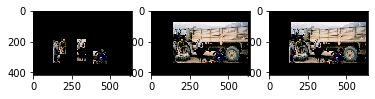

[*] Predictions
[1] motorcycle sit_on 7.85%
[2] motorcycle ride 7.41%
[3] motorcycle straddle 6.55%
[4] umbrella hold 5.94%
[5] motorcycle hold 5.57%
Ground truth: truck ride
[[381, 300, 408, 361], [332, 299, 376, 362], [273, 501, 311, 550], [276, 462, 298, 523], [299, 441, 316, 488], [219, 403, 231, 437]] [[24, 104, 307, 256]]
{'skateboard': [24, 104, 307, 256]}


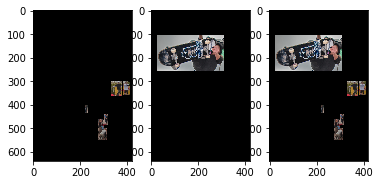

[*] Predictions
[1] umbrella hold 17.42%
[2] umbrella carry 16.29%
[3] umbrella stand_under 14.19%
[4] kite fly 8.68%
[5] kite pull 6.35%
Ground truth: skateboard grind
[[447, 359, 454, 369]] [[60, 79, 625, 416]]
{'airplane': [60, 79, 625, 416]}


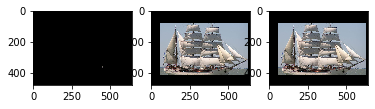

[*] Predictions
[1] airplane fly 15.3%
[2] airplane sit_on 13.43%
[3] airplane ride 11.67%
[4] boat ride 11.11%
[5] bus ride 10.27%
Ground truth: boat row
[] []
{}


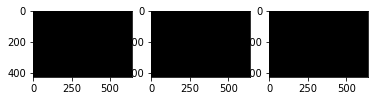

[*] Predictions
[1] snowboard wear 6.88%
[2] snowboard stand_on 5.58%
[3] snowboard ride 5.22%
[4] snowboard jump 5.11%
[5] traffic_light no_interaction 4.54%
Ground truth: sports_ball catch
[] [[511, 267, 555, 312], [443, 192, 481, 282]]
{'cat': [511, 267, 555, 312], 'fire hydrant': [443, 192, 481, 282]}


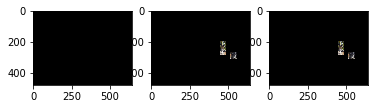

[*] Predictions
[1] snowboard wear 7.89%
[2] snowboard stand_on 6.51%
[3] snowboard ride 6.03%
[4] traffic_light no_interaction 5.99%
[5] snowboard jump 5.09%
Ground truth: backpack hold
[[76, 117, 286, 493], [0, 64, 60, 267], [291, 51, 376, 248], [99, 75, 157, 169], [367, 75, 383, 98], [386, 76, 402, 96]] [[286, 125, 316, 180], [401, 122, 427, 179], [441, 120, 470, 168]]
{'chair': [441, 120, 470, 168]}


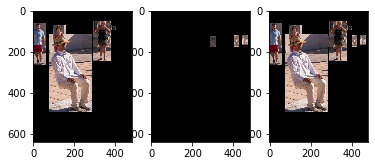

[*] Predictions
[1] skateboard ride 8.39%
[2] skateboard stand_on 7.9%
[3] skateboard jump 7.16%
[4] book read 2.94%
[5] skateboard flip 2.64%
Ground truth: couch carry
[[171, 28, 508, 355], [131, 76, 272, 297], [268, 3, 631, 358], [15, 26, 272, 290], [91, 81, 346, 325]] []
{}


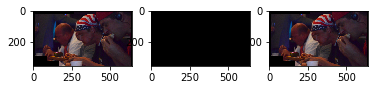

[*] Predictions
[1] cell_phone hold 4.77%
[2] wine_glass hold 4.09%
[3] book read 3.83%
[4] baseball_bat hold 3.66%
[5] knife wield 3.53%
Ground truth: sandwich hold
[[273, 37, 477, 293], [535, 55, 581, 122]] [[277, 84, 513, 324]]
{'motorcycle': [277, 84, 513, 324]}


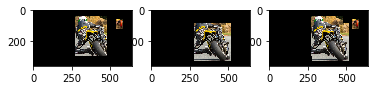

[*] Predictions
[1] bicycle straddle 32.13%
[2] motorcycle sit_on 28.86%
[3] bicycle ride 25.46%
[4] motorcycle ride 24.32%
[5] motorcycle straddle 22.97%
Ground truth: motorcycle ride
[] [[143, 42, 361, 443], [320, 49, 624, 467], [512, 28, 608, 232], [0, 233, 79, 474], [0, 144, 640, 472], [127, 146, 170, 183], [518, 3, 614, 94]]
{'wine glass': [320, 49, 624, 467], 'bottle': [518, 3, 614, 94], 'dining table': [0, 144, 640, 472], 'knife': [127, 146, 170, 183]}


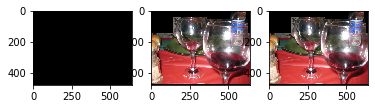

[*] Predictions
[1] dining_table sit_at 14.88%
[2] dining_table eat_at 11.66%
[3] horse ride 3.71%
[4] horse straddle 3.26%
[5] horse hold 3.02%
Ground truth: zebra feed
[[124, 81, 265, 254], [368, 95, 538, 468], [371, 92, 533, 291], [129, 152, 157, 247]] [[0, 235, 59, 366], [312, 159, 343, 277], [378, 235, 415, 316], [184, 207, 225, 274], [294, 156, 320, 252], [12, 210, 514, 469], [238, 219, 260, 257], [413, 248, 435, 279], [108, 211, 138, 249], [79, 266, 211, 345], [314, 151, 328, 208], [274, 285, 308, 317]]
{'cup': [413, 248, 435, 279], 'bottle': [314, 151, 328, 208], 'wine glass': [184, 207, 225, 274], 'dining table': [12, 210, 514, 469], 'chair': [108, 211, 138, 249], 'bowl': [79, 266, 211, 345], 'broccoli': [274, 285, 308, 317]}


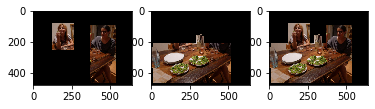

[*] Predictions
[1] dining_table sit_at 46.2%
[2] dining_table eat_at 34.33%
[3] bicycle straddle 9.57%
[4] bicycle ride 7.95%
[5] bicycle hold 7.16%
Ground truth: dining_table sit_at
[[311, 55, 504, 312], [55, 56, 438, 420]] [[289, 264, 520, 418], [406, 246, 426, 281], [502, 259, 574, 313], [462, 249, 511, 279], [487, 58, 634, 250], [101, 89, 128, 109]]
{'laptop': [289, 264, 520, 418], 'cup': [406, 246, 426, 281], 'keyboard': [502, 259, 574, 313], 'book': [462, 249, 511, 279], 'chair': [487, 58, 634, 250], 'traffic light': [101, 89, 128, 109]}


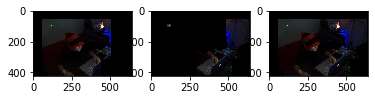

[*] Predictions
[1] bench sit_on 9.77%
[2] chair sit_on 7.21%
[3] backpack wear 7.2%
[4] umbrella hold 7.11%
[5] backpack carry 6.98%
Ground truth: laptop open
[[478, 92, 571, 354], [125, 59, 227, 228], [145, 168, 281, 323], [64, 69, 72, 89], [83, 97, 172, 246], [546, 81, 595, 213], [47, 72, 53, 86], [543, 71, 629, 108]] [[0, 243, 529, 425], [360, 81, 413, 101], [234, 83, 268, 96]]
{'boat': [0, 243, 529, 425], 'bicycle': [360, 81, 413, 101], 'bench': [234, 83, 268, 96]}


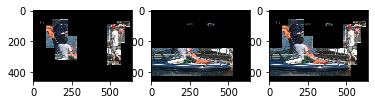

[*] Predictions
[1] dining_table sit_at 20.41%
[2] bench sit_on 17.74%
[3] dining_table eat_at 12.09%
[4] bicycle straddle 11.22%
[5] bicycle ride 9.69%
Ground truth: boat row
[[218, 31, 610, 358]] []
{}


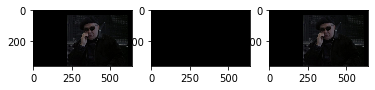

[*] Predictions
[1] backpack wear 10.17%
[2] backpack carry 10.13%
[3] skateboard stand_on 9.28%
[4] skateboard ride 8.8%
[5] umbrella hold 8.05%
Ground truth: bench no_interaction
[[8, 10, 142, 420], [541, 114, 576, 191], [124, 107, 236, 287], [440, 96, 477, 196], [290, 83, 312, 140], [569, 123, 597, 190], [192, 74, 202, 101], [262, 77, 284, 139], [400, 93, 451, 195], [213, 70, 236, 126], [334, 88, 357, 149], [240, 76, 255, 129], [359, 97, 378, 149], [163, 75, 170, 93], [313, 94, 334, 138], [375, 103, 398, 176], [534, 116, 555, 185], [276, 81, 291, 138], [400, 95, 425, 185], [555, 119, 589, 191], [0, 296, 21, 406]] [[152, 223, 469, 453], [533, 152, 546, 177], [322, 211, 364, 242], [579, 147, 598, 163], [386, 199, 489, 328]]
{'dining table': [152, 223, 469, 453], 'handbag': [579, 147, 598, 163], 'bowl': [322, 211, 364, 242], 'refrigerator': [386, 199, 489, 328]}


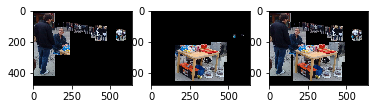

[*] Predictions
[1] bicycle straddle 28.37%
[2] bicycle ride 24.17%
[3] bicycle hold 16.15%
[4] bicycle sit_on 13.55%
[5] motorcycle straddle 9.67%
Ground truth: parking_meter check
[[3, 19, 317, 473], [575, 339, 590, 364]] [[355, 382, 639, 476]]
{'dog': [355, 382, 639, 476]}


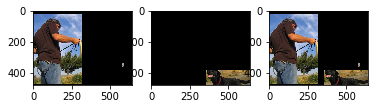

[*] Predictions
[1] bench sit_on 3.49%
[2] umbrella hold 3.17%
[3] umbrella carry 2.97%
[4] baseball_bat hold 2.82%
[5] cell_phone hold 2.78%
Ground truth: giraffe feed
[[313, 130, 388, 278]] [[373, 223, 429, 320], [2, 221, 70, 363], [56, 228, 107, 357], [90, 235, 200, 397], [106, 30, 373, 238], [267, 256, 386, 421], [438, 218, 507, 303], [520, 306, 544, 355], [361, 289, 625, 418], [319, 226, 376, 329], [475, 225, 516, 303], [69, 221, 112, 242], [157, 217, 208, 343], [105, 31, 380, 114], [538, 304, 556, 349], [534, 221, 626, 318], [487, 210, 525, 272], [224, 234, 288, 371], [250, 211, 271, 235], [229, 212, 251, 234], [548, 244, 637, 266], [157, 218, 207, 277]]
{'chair': [157, 218, 207, 277], 'umbrella': [105, 31, 380, 114], 'bottle': [538, 304, 556, 349], 'dining table': [548, 244, 637, 266], 'cup': [229, 212, 251, 234]}


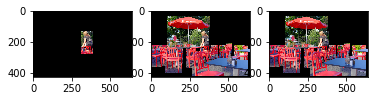

[*] Predictions
[1] dining_table sit_at 6.33%
[2] dining_table eat_at 5.21%
[3] horse ride 1.9%
[4] bicycle straddle 1.8%
[5] bicycle hold 1.76%
Ground truth: vase hold
[[284, 107, 406, 235], [108, 105, 258, 283], [0, 83, 131, 370], [454, 76, 623, 397], [532, 64, 638, 408]] [[118, 280, 175, 392], [192, 275, 234, 376], [455, 296, 497, 408], [494, 309, 554, 388], [279, 396, 298, 428], [86, 229, 584, 427], [312, 231, 327, 258], [373, 229, 402, 278], [406, 208, 423, 246], [444, 165, 498, 244], [256, 249, 292, 298], [461, 198, 484, 226], [294, 211, 314, 245], [279, 396, 317, 429], [357, 281, 404, 309], [448, 266, 496, 324], [225, 292, 266, 354]]
{'wine glass': [294, 211, 314, 245], 'cup': [225, 292, 266, 354], 'fork': [279, 396, 317, 429], 'dining table': [86, 229, 584, 427], 'potted plant': [444, 165, 498, 244], 'vase': [461, 198, 484, 226], 'bowl': [357, 281, 404, 309]}


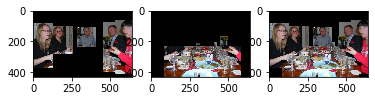

[*] Predictions
[1] dining_table sit_at 77.26%
[2] dining_table eat_at 58.77%
[3] bench sit_on 14.37%
[4] bicycle straddle 7.49%
[5] bicycle ride 6.19%
Ground truth: dining_table sit_at
[[94, 14, 273, 180], [560, 173, 578, 208], [490, 199, 499, 222], [465, 193, 491, 226], [516, 192, 523, 216], [502, 193, 509, 214], [464, 192, 476, 226], [509, 193, 518, 216]] [[362, 251, 394, 273], [362, 222, 488, 272], [111, 182, 215, 229]]
{'bench': [362, 222, 488, 272], 'skateboard': [111, 182, 215, 229]}


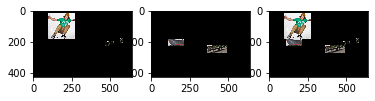

[*] Predictions
[1] skateboard jump 28.36%
[2] skateboard ride 24.35%
[3] skateboard stand_on 22.44%
[4] snowboard wear 15.94%
[5] snowboard stand_on 15.89%
Ground truth: skateboard pick_up
[[2, 49, 78, 215]] [[435, 5, 503, 43], [48, 101, 612, 362], [580, 30, 639, 70], [614, 51, 639, 86], [33, 148, 395, 350], [335, 86, 475, 120]]
{'car': [335, 86, 475, 120]}


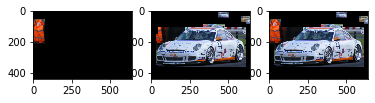

[*] Predictions
[1] airplane fly 12.73%
[2] boat ride 11.33%
[3] car ride 9.74%
[4] car drive 8.47%
[5] car no_interaction 8.21%
Ground truth: car wash
[[31, 155, 444, 640]] [[200, 408, 292, 636]]
{'tie': [200, 408, 292, 636]}


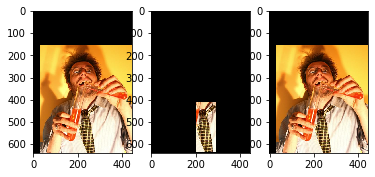

[*] Predictions
[1] dining_table sit_at 40.52%
[2] dining_table eat_at 29.4%
[3] bed lie_on 3.57%
[4] bottle hold 2.95%
[5] wine_glass hold 2.84%
Ground truth: tie no_interaction
[[0, 205, 371, 626], [1, 265, 206, 639]] [[79, 452, 186, 624]]
{'bottle': [79, 452, 186, 624]}


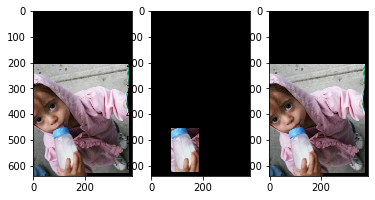

[*] Predictions
[1] bottle hold 3.87%
[2] tie wear 3.69%
[3] cell_phone hold 2.95%
[4] bottle drink_with 2.82%
[5] wine_glass hold 2.82%
Ground truth: bottle drink_with
[] [[124, 123, 484, 445]]
{'dog': [124, 123, 484, 445]}


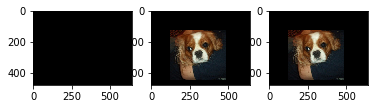

[*] Predictions
[1] elephant watch 10.01%
[2] horse ride 5.52%
[3] umbrella hold 4.64%
[4] person hold 4.6%
[5] motorcycle ride 4.5%
Ground truth: dog dry
[[280, 101, 402, 201], [478, 66, 639, 278], [423, 95, 517, 221], [3, 31, 133, 303], [123, 63, 291, 228], [27, 13, 122, 196], [0, 34, 76, 267], [471, 78, 525, 153]] [[496, 307, 555, 386], [173, 311, 234, 430], [444, 373, 581, 471], [407, 238, 442, 296], [461, 236, 515, 259], [174, 233, 235, 263], [381, 293, 431, 338], [364, 213, 393, 261], [169, 262, 283, 303], [465, 259, 528, 293], [381, 285, 430, 377], [286, 249, 319, 309], [5, 196, 633, 476], [447, 295, 545, 341], [249, 364, 440, 448], [569, 328, 639, 381], [374, 190, 395, 210], [188, 169, 232, 199], [545, 267, 608, 346], [278, 218, 303, 248], [570, 378, 640, 455], [291, 189, 309, 220], [0, 271, 20, 332]]
{'cup': [0, 271, 20, 332], 'bowl': [570, 378, 640, 455], 'dining table': [5, 196, 633, 476], 'spoon': [545, 267, 608, 346]}


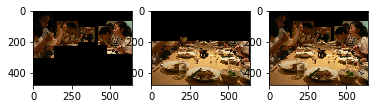

[*] Predictions
[1] dining_table sit_at 95.19%
[2] dining_table eat_at 92.19%
[3] bed lie_on 11.6%
[4] cake blow 8.3%
[5] couch sit_on 2.4%
Ground truth: dining_table sit_at
[[270, 124, 608, 460], [39, 101, 446, 454]] [[343, 296, 461, 455]]
{'tie': [343, 296, 461, 455]}


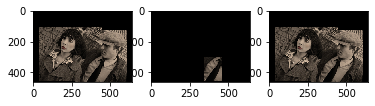

[*] Predictions
[1] bench sit_on 5.22%
[2] wine_glass hold 2.32%
[3] person hold 1.72%
[4] book read 1.66%
[5] book hold 1.57%
Ground truth: tie no_interaction
[[34, 36, 479, 615]] [[271, 238, 342, 395], [318, 405, 379, 613]]
{'tie': [271, 238, 342, 395], 'bottle': [318, 405, 379, 613]}


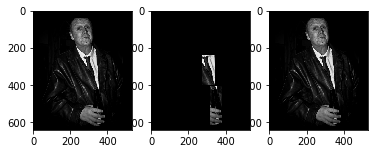

[*] Predictions
[1] umbrella hold 8.06%
[2] umbrella carry 7.77%
[3] skateboard stand_on 5.23%
[4] umbrella stand_under 5.19%
[5] backpack wear 5.1%
Ground truth: bottle inspect
[[482, 3, 636, 246]] [[97, 43, 450, 371], [0, 112, 105, 263]]
{'cake': [97, 43, 450, 371], 'chair': [0, 112, 105, 263]}


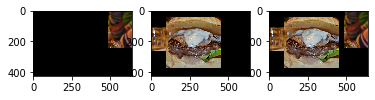

[*] Predictions
[1] person hold 1.8%
[2] elephant watch 1.71%
[3] bed lie_on 1.4%
[4] bench sit_on 1.15%
[5] chair sit_on 1.03%
Ground truth: scissors cut_with
[[326, 91, 448, 311], [117, 92, 261, 359]] [[51, 192, 347, 405], [344, 187, 624, 375], [191, 283, 222, 321]]
{'bicycle': [344, 187, 624, 375], 'bottle': [191, 283, 222, 321]}


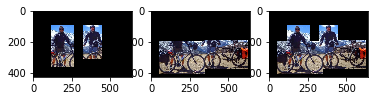

[*] Predictions
[1] bicycle straddle 41.31%
[2] bicycle ride 38.59%
[3] bicycle hold 35.22%
[4] bicycle sit_on 18.99%
[5] bench sit_on 13.51%
Ground truth: bicycle inspect
[[41, 217, 334, 630], [318, 262, 425, 477], [0, 370, 63, 631], [242, 246, 325, 421]] []
{}


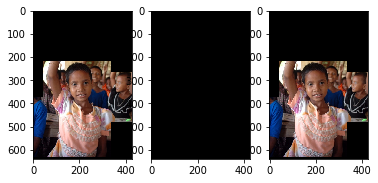

[*] Predictions
[1] dining_table sit_at 42.99%
[2] dining_table eat_at 22.43%
[3] bottle hold 4.29%
[4] tie wear 3.67%
[5] cake blow 3.48%
Ground truth: potted_plant carry
[[210, 156, 411, 589], [207, 162, 399, 389]] [[538, 348, 590, 397], [0, 209, 557, 544], [4, 211, 294, 573], [566, 414, 639, 594], [478, 322, 510, 345], [102, 447, 161, 465]]
{'cup': [538, 348, 590, 397], 'couch': [4, 211, 294, 573], 'chair': [566, 414, 639, 594], 'remote': [478, 322, 510, 345], 'bowl': [102, 447, 161, 465]}


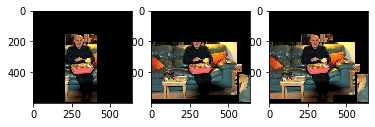

[*] Predictions
[1] dining_table sit_at 13.0%
[2] dining_table eat_at 8.65%
[3] bench sit_on 7.62%
[4] person hold 4.16%
[5] bicycle straddle 3.41%
Ground truth: toilet clean
[[375, 40, 611, 381], [6, 75, 286, 389], [39, 73, 226, 300]] [[465, 200, 483, 259], [16, 181, 190, 393], [378, 185, 402, 222], [579, 108, 638, 228], [566, 211, 639, 328]]
{'bottle': [378, 185, 402, 222], 'chair': [16, 181, 190, 393], 'handbag': [566, 211, 639, 328]}


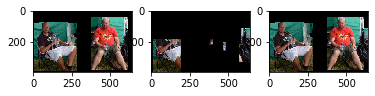

[*] Predictions
[1] bench sit_on 2.78%
[2] wine_glass hold 2.73%
[3] tie wear 2.51%
[4] cell_phone hold 1.67%
[5] person hold 1.65%
Ground truth: chair stand_on
[[237, 72, 480, 293]] [[126, 129, 606, 379]]
{'motorcycle': [126, 129, 606, 379]}


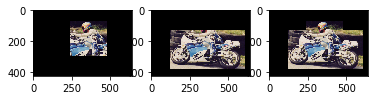

[*] Predictions
[1] motorcycle straddle 38.63%
[2] motorcycle sit_on 35.15%
[3] motorcycle ride 32.6%
[4] motorcycle hold 23.61%
[5] bicycle straddle 23.53%
Ground truth: motorcycle inspect
[[508, 77, 604, 287]] [[239, 204, 323, 255], [150, 135, 211, 213], [307, 252, 343, 321], [303, 366, 320, 457], [32, 154, 504, 475], [321, 172, 353, 296], [303, 109, 317, 171], [53, 282, 116, 386], [362, 133, 378, 168], [0, 43, 79, 107], [350, 316, 440, 376], [312, 118, 329, 185], [271, 368, 319, 457], [268, 236, 309, 326], [309, 218, 354, 324], [48, 279, 105, 340], [208, 198, 238, 237], [380, 158, 416, 176], [162, 216, 227, 258], [169, 354, 266, 415], [84, 204, 163, 267], [476, 287, 632, 472]]
{'bowl': [169, 354, 266, 415], 'chair': [476, 287, 632, 472], 'wine glass': [309, 218, 354, 324], 'fork': [271, 368, 319, 457], 'dining table': [32, 154, 504, 475], 'bottle': [268, 236, 309, 326], 'potted plant': [0, 43, 79, 107], 'cup': [208, 198, 238, 237]}


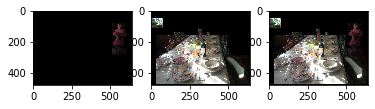

[*] Predictions
[1] dining_table sit_at 18.71%
[2] dining_table eat_at 13.17%
[3] person hold 2.26%
[4] bed lie_on 2.05%
[5] bench sit_on 2.04%
Ground truth: dog carry
[[154, 251, 376, 399]] [[0, 110, 228, 396]]
{'surfboard': [0, 110, 228, 396]}


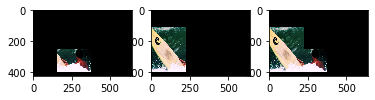

[*] Predictions
[1] bench sit_on 16.12%
[2] bicycle hold 4.2%
[3] bicycle straddle 3.3%
[4] bicycle ride 2.88%
[5] skis stand_on 2.77%
Ground truth: surfboard inspect
[[223, 148, 306, 379]] [[266, 178, 616, 321], [239, 186, 285, 236]]
{'car': [266, 178, 616, 321], 'backpack': [239, 186, 285, 236]}


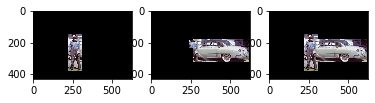

[*] Predictions
[1] bench sit_on 20.21%
[2] boat ride 9.64%
[3] boat sit_on 7.84%
[4] boat row 4.03%
[5] boat stand_on 3.01%
Ground truth: cat dry
[[111, 92, 424, 384]] [[192, 220, 497, 387]]
{'bench': [192, 220, 497, 387]}


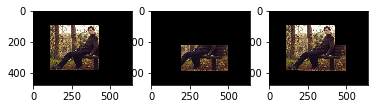

[*] Predictions
[1] bicycle straddle 24.21%
[2] bicycle ride 18.39%
[3] bicycle hold 17.72%
[4] motorcycle straddle 17.27%
[5] motorcycle sit_on 15.67%
Ground truth: bench no_interaction
[[386, 228, 479, 628], [9, 257, 95, 409], [28, 222, 251, 619], [55, 199, 406, 639], [183, 250, 355, 632], [171, 297, 250, 457], [0, 311, 85, 619], [34, 256, 114, 358]] []
{}


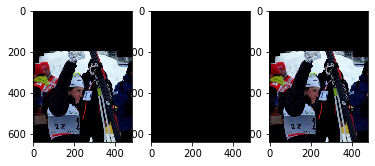

[*] Predictions
[1] tie wear 7.28%
[2] kite pull 2.75%
[3] kite fly 2.53%
[4] umbrella carry 2.4%
[5] skis wear 2.14%
Ground truth: skis hold
[[0, 38, 33, 211]] [[265, 200, 377, 312], [1, 200, 107, 373], [0, 181, 441, 640]]
{'laptop': [265, 200, 377, 312], 'bed': [0, 181, 441, 640]}


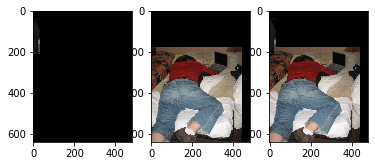

[*] Predictions
[1] dining_table sit_at 8.29%
[2] bed lie_on 6.21%
[3] dining_table eat_at 6.06%
[4] bed sit_on 2.15%
[5] car no_interaction 1.85%
Ground truth: bed sit_on
[[285, 245, 328, 306]] []
{}


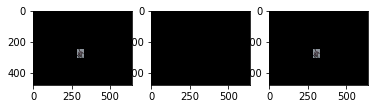

[*] Predictions
[1] snowboard wear 9.44%
[2] snowboard stand_on 7.65%
[3] snowboard ride 7.06%
[4] snowboard jump 6.61%
[5] skateboard ride 4.41%
Ground truth: skis stand_on
[[392, 104, 449, 194], [393, 104, 479, 219]] [[529, 192, 566, 291], [481, 194, 512, 288], [387, 158, 483, 369], [265, 142, 353, 299], [332, 173, 391, 291], [115, 148, 230, 348], [54, 136, 128, 289], [194, 131, 268, 275]]
{'cow': [194, 131, 268, 275], 'horse': [115, 148, 230, 348]}


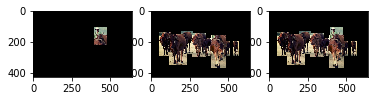

[*] Predictions
[1] horse ride 26.49%
[2] horse straddle 19.6%
[3] horse hold 13.18%
[4] horse run 8.29%
[5] elephant watch 7.73%
Ground truth: cow hold
[[58, 528, 148, 617], [261, 62, 349, 272]] [[3, 585, 205, 639]]
{'bench': [3, 585, 205, 639]}


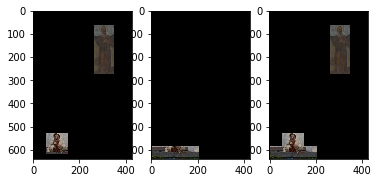

[*] Predictions
[1] skateboard ride 6.94%
[2] skateboard stand_on 5.75%
[3] skateboard jump 5.23%
[4] umbrella carry 3.49%
[5] umbrella hold 2.9%
Ground truth: bench no_interaction
[[1, 96, 426, 626]] []
{}


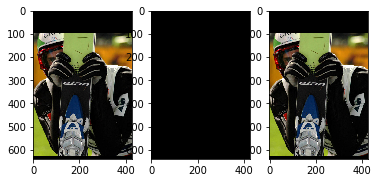

[*] Predictions
[1] umbrella carry 10.91%
[2] tie wear 8.28%
[3] umbrella hold 7.41%
[4] umbrella stand_under 6.18%
[5] cell_phone hold 4.4%
Ground truth: skis hold
[[118, 2, 321, 253], [558, 0, 632, 138], [506, 0, 569, 147], [127, 0, 163, 104], [448, 3, 479, 98], [467, 2, 507, 98], [602, 4, 632, 109]] [[144, 149, 204, 252]]
{'skateboard': [144, 149, 204, 252]}


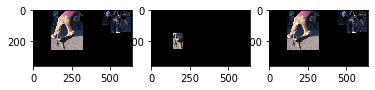

[*] Predictions
[1] skateboard stand_on 21.63%
[2] skateboard ride 21.1%
[3] skateboard jump 16.54%
[4] snowboard stand_on 6.51%
[5] snowboard wear 6.46%
Ground truth: skateboard grind
[[259, 9, 484, 337]] [[268, 276, 498, 396]]
{'snowboard': [268, 276, 498, 396]}


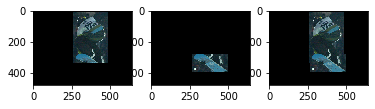

[*] Predictions
[1] skateboard ride 17.81%
[2] skateboard jump 14.88%
[3] skateboard stand_on 14.48%
[4] snowboard stand_on 12.59%
[5] snowboard wear 12.4%
Ground truth: snowboard jump
[[68, 37, 416, 348]] [[111, 162, 283, 582]]
{'bicycle': [111, 162, 283, 582]}


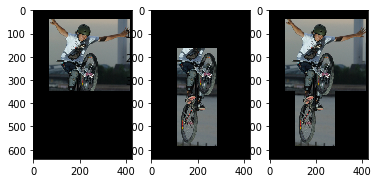

[*] Predictions
[1] motorcycle ride 17.29%
[2] motorcycle sit_on 13.88%
[3] motorcycle straddle 13.2%
[4] motorcycle hold 11.05%
[5] bicycle straddle 7.85%
Ground truth: bicycle hop_on


KeyboardInterrupt: 

In [51]:
from random import randint
from matplotlib import pyplot as plt

%matplotlib inline

with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
    
with open('datasets/processed/hico/anno_list.json') as f:
    anno_list = json.load(f)

def run_prediction(img_id):
    IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_" + str(img_id).rjust(8, '0') + ".jpg"
    im = Image.open(IMG_PATH)
    #display(im)
    
    src = cv2.imread(IMG_PATH)
    src = src/255
    img_tensor = torch.from_numpy(src)
    img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
    rcnn_input = [img_tensor]
    
    out = faster_rcnn(rcnn_input)[0]
    
    human_bboxes, object_bboxes = [], []
    object_dic = {}
    for i in range(len(out['boxes'])):
        if out['scores'][i] < .7:
            break
        bbox = list(map(int, out['boxes'][i]))
        if out['labels'][i] == 1: # human
            human_bboxes.append(bbox)
        else: 
            object_bboxes.append(bbox)
            object_dic[coco_dict[out['labels'][i]]] = bbox

    print(human_bboxes, object_bboxes)
    print(object_dic)
    
    # Apply masks
    src = cv2.imread(IMG_PATH)
    human_mask = np.zeros_like(src)
    for bbox in human_bboxes:
        cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

    obj_mask = np.zeros_like(src)
    pairwise_mask = human_mask
    for bbox in object_bboxes:
        cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
        cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
    pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

    # Visualize images
    f, axarr = plt.subplots(1,3)

    human_bbox_rgb = cv2.cvtColor(human_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[0].imshow(human_bbox_rgb)

    object_mask_rgb = cv2.cvtColor(obj_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[1].imshow(object_mask_rgb)

    pairwise_rgb = cv2.cvtColor(pairwise_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[2].imshow(pairwise_rgb)
    
    plt.show()
    f.clf()
    
    # resize images
    human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)

    human_bbox_img = human_bbox_img/255
    obj_bbox_img = obj_bbox_img/255
    pairwise_bbox_img = pairwise_bbox_img/255
    
    human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
    obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
    pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)

    res_human_input = human_bbox_img.unsqueeze(0)
    res_obj_input = obj_bbox_img.unsqueeze(0)
    res_pairwise_input = pairwise_bbox_img.unsqueeze(0)

    res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
    res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
    res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)
    
    with torch.no_grad(): # Disable gradients for validation
        outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)
        preds = torch.argmax(outputs, dim=1)
        
    confidences = F.sigmoid(outputs)
    top5preds = torch.topk(confidences, 5)
    top5_idx = top5preds[1].flatten()
    top5_confidence = top5preds[0].flatten()
    print('[*] Predictions')
    for i in range(len(top5_idx)):
        prediction = hoi_list[top5_idx[i]]
        print('[' + str(i + 1) + '] ' + prediction['object'] + ' ' + prediction['verb'] \
              + ' ' + str(round(top5_confidence[i].item() * 100, 2)) + '%')
    
    ground_data = [x for x in anno_list if x['global_id'] == "HICO_test2015_" + str(img_id).rjust(8, '0')][0]
    ground_truth = ground_data['hois'][0]
    img_id = int(ground_truth['id'])
    print('Ground truth: ' + hoi_list[img_id]['object'] + ' ' + hoi_list[img_id]['verb'])
    
from time import sleep
while True:
    img_id = randint(1, 1000)
    run_prediction(img_id)
    sleep(5)

# HOPoseCNN

In [ ]:
from model.cnn_with_pose import HOPOSECNN

model = "hicopose/v3_2020-11-04_00-14/"
checkpoint_path = "checkpoint_45_epoch.pth"

POSE_PATH = "checkpoints/" + model + "epoch_train/" + checkpoint_path

In [ ]:
pose_checkpoint = torch.load(POSE_PATH, map_location=device)
pose_model = HOPOSECNN().to(device)
pose_model.load_state_dict(pose_checkpoint['state_dict'])
pose_model.eval()
print("model loaded")

In [ ]:
from random import randint
from matplotlib import pyplot as plt

%matplotlib inline

with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
    
with open('datasets/processed/hico/anno_list.json') as f:
    anno_list = json.load(f)

def run_prediction(img_id):
    IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_" + str(img_id).rjust(8, '0') + ".jpg"
    POSE_PATH = "datasets/human_pose/test2015/HICO_test2015_" + str(img_id).rjust(8, '0') + "_keypoints.json"
    im = Image.open(IMG_PATH)
    display(im)
    with open(POSE_PATH) as f:
        pose_data = json.load(f)
    
    src = cv2.imread(IMG_PATH)
    src = src/255
    img_tensor = torch.from_numpy(src)
    img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
    rcnn_input = [img_tensor]
    
    out = faster_rcnn(rcnn_input)[0]
    
    human_bboxes, object_bboxes = [], []
    object_dic = {}
    for i in range(len(out['boxes'])):
        if out['scores'][i] < .7:
            break
        bbox = list(map(int, out['boxes'][i]))
        if out['labels'][i] == 1: # human
            human_bboxes.append(bbox)
        else: 
            object_bboxes.append(bbox)
            object_dic[coco_dict[out['labels'][i]]] = bbox

    print(human_bboxes, object_bboxes)
    print(object_dic)
    
    pose_img = np.zeros((src.shape[0], src.shape[1], 1))
    
    for person in pose_data['people']:
        pose_data_2d = person['pose_keypoints_2d']
        prev_point = None
        for inner_point in range(0, len(pose_data_2d), 3):
            x, y, c = pose_data_2d[inner_point], pose_data_2d[inner_point + 1], pose_data_2d[inner_point + 2]
            if c > 0:
                pose_img = cv2.circle(pose_img, (int(x), int(y)), 10, (255,0,0), \
                                      thickness=-1, lineType=cv2.FILLED)
                if prev_point:
                    pose_img = cv2.line(pose_img, (int(prev_point[0]), int(prev_point[1])), \
                                        (int(x), int(y)), (255, 0, 0), 3)
                prev_point = (x, y)
    
    # apply masks
    src = cv2.imread(IMG_PATH)
    human_mask = np.zeros_like(src)
    for bbox in human_bboxes:
        cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

    obj_mask = np.zeros_like(src)
    pairwise_mask = human_mask
    for bbox in object_bboxes:
        cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
        cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
    pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

    # Visualize images
    f, axarr = plt.subplots(1,4)

    human_bbox_rgb = cv2.cvtColor(human_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[0].imshow(human_bbox_rgb)

    object_mask_rgb = cv2.cvtColor(obj_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[1].imshow(object_mask_rgb)

    pairwise_rgb = cv2.cvtColor(pairwise_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[2].imshow(pairwise_rgb)
    
    zeroed_channel = np.zeros((src.shape[0], src.shape[1], 1))
    stacked_pose_img = np.dstack((pose_img, zeroed_channel, zeroed_channel))
    axarr[3].imshow(stacked_pose_img)
    
    plt.show()
    f.clf()
    
    # resize images
    human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    pose_img = cv2.resize(pose_img, (64, 64), interpolation=cv2.INTER_AREA)

    human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
    obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
    pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)
    pose_img = torch.from_numpy(pose_img).to(device)

    res_human_input = human_bbox_img.unsqueeze(0)
    res_obj_input = obj_bbox_img.unsqueeze(0)
    res_pairwise_input = pairwise_bbox_img.unsqueeze(0)
    res_pose_input = pose_img.unsqueeze(0)
    
    res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
    res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
    res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)
    res_pose_input = res_pose_input.unsqueeze(3).permute([0,3,1,2]).float().to(device)
    
    with torch.no_grad(): # Disable gradients for validation
        outputs = pose_model.forward(res_human_input, res_obj_input, res_pairwise_input, res_pose_input)
        preds = torch.argmax(outputs, dim=1)
        
    prediction = hoi_list[preds.item() + 1]
    print('Predicted label: ' + str(prediction))
    
    ground_data = [x for x in anno_list if x['global_id'] == "HICO_test2015_" + str(img_id).rjust(8, '0')][0]
    ground_truth = ground_data['hois'][0]
    img_id = int(ground_truth['id'])
    print('Ground truth label: ' + str(hoi_list[img_id]))
    
from time import sleep
run_prediction(randint(1, 1000))
'''
while True:
    img_id = randint(1, 1000)
    run_prediction(img_id)
    sleep(5)
'''